## Overview

#### Objective
To  process the given data and create a visualization using the pre-processed dataset.     

#### Dataset
The data is organized into folders by year-month and parameter (PR or GHI). 

* _**PR (Performance Ratio):**_ This parameter is used to track the daily performance of the PV 
plant. A high value indicates that the plant is performing well and there are no issues.     
* _**GHI (Global Horizontal Irradiance):**_ This parameter tracks the total irradiation for a particular 
day. A high value indicates a sunny day.

For example, 

PR/  
&nbsp;&nbsp;&nbsp;&nbsp;2023-01/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2023-01-01_PR.csv  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2023-01-06_PR.csv  

GHI/  
&nbsp;&nbsp;&nbsp;&nbsp;2023-01/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2023-01-01_GHI.csv  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;2023-01-06_GHI.csv 




##### Import Necessary Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from datetime import datetime, timedelta
import matplotlib.dates as mdates     # Import for date formatting
from matplotlib.lines import Line2D    # Import Line2D for custom legend handles

In [2]:
# Path to directory
data_directory_path = "D:\Assignment\data" 

### Data Preprocessing

For this combine PR (Performance Ratio) and GHI (Global Horizontal Irradiance) data from various CSV files into a single CSV file with three columns: Date, GHI, and PR. The final CSV should contain 982 rows. It's required to create a single, readable function for this preprocessing.


Steps for the Preprocessing Function:
* Traverse through the PR and GHI directories.
* For each day, read both the PR and GHI CSV files.
* From each CSV, extract the relevant daily value. The date can be extracted from the filename.
* Create a structure a Pandas DataFrame to hold the Date, GHI, and PR for each day.
* Handle Missing Data (if any)
* Once all data is collected, save it into a single CSV file.

In [3]:
def data_preprocess(data_dir) : 
    """
    Processes PR and GHI data from the specified directory structure and generates a single CSV file.
    """

    print(f"\nPreprocessing data from: {data_dir}")

    pr_dir = os.path.join(data_dir, 'PR')
    ghi_dir = os.path.join(data_dir, 'GHI')

    print(f"\n Checking PR directory: {pr_dir}")
    if not os.path.isdir(pr_dir):
        print(f"\nError: PR directory not found or is not a directory at {pr_dir}")
        return None
    print(f"Checking GHI directory: {ghi_dir}")
    if not os.path.isdir(ghi_dir):
        print(f"\nError: GHI directory not found or is not a directory at {ghi_dir}")
        return None

    all_data = []
    
    # Collect all PR file dates first (for efficient pairing)
    pr_files_map = {}    # Maps date_str to full file path
    total_pr_files_found = 0
    
    for year_month in sorted(os.listdir(pr_dir)):
        current_pr_month_path = os.path.join(pr_dir, year_month)
        if os.path.isdir(current_pr_month_path):
            for pr_filename in sorted(os.listdir(current_pr_month_path)):
                if pr_filename.endswith('.csv'):
                    date_str = pr_filename.replace('.csv', '')
                    try:
                        pd.to_datetime(date_str)    # Validate date string
                        pr_files_map[date_str] = os.path.join(current_pr_month_path, pr_filename)
                        total_pr_files_found += 1
                    except ValueError:
                        print(f"\nSkipping non-date or malformed PR file: {pr_filename} in {current_pr_month_path}")
                else:
                    print(f"\nSkipping non-CSV PR file: {pr_filename} in {current_pr_month_path}")

    # Iterate through GHI files and process only if a matching PR file exists
    paired_files_count = 0
    total_ghi_files_found = 0
    
    for year_month in sorted(os.listdir(ghi_dir)):
        current_ghi_month_path = os.path.join(ghi_dir, year_month)
        
        if not os.path.isdir(current_ghi_month_path):
            print(f"Skipping non-directory item in GHI folder: {current_ghi_month_path}")
            continue

        for ghi_filename in sorted(os.listdir(current_ghi_month_path)):
            if ghi_filename.endswith('.csv'):
                date_str = ghi_filename.replace('.csv', '')
                try:
                    current_date = pd.to_datetime(date_str)    # Validate date string
                    total_ghi_files_found += 1
                    
                    if date_str in pr_files_map:
                        pr_file_path = pr_files_map[date_str]
                        ghi_file_path = os.path.join(current_ghi_month_path, ghi_filename)

                        # print(f"Attempting to process: PR: {pr_file_path}, GHI: {ghi_file_path}")     # Uncomment for detailed debug

                        try:
                            # Read PR value (the value is in the first data row, second column, after header)
                            pr_value = pd.read_csv(pr_file_path).iloc[0, 1]
                            # Read GHI value (the value is in the first data row, second column, after header)
                            ghi_value = pd.read_csv(ghi_file_path).iloc[0, 1]

                            all_data.append({
                                'Date': current_date,
                                'GHI': float(ghi_value),
                                'PR': float(pr_value)
                            })
                            paired_files_count += 1
                            # print(f"Successfully processed data for {date_str}")     # Uncomment for detailed debug
                        except Exception as e:
                            print(f"\nWarning: Could not read data from files for {date_str}. Error: {e}")
                    else:
                        print(f"\nWarning: GHI file for {date_str} found, but no matching PR file. Skipping. Path: {os.path.join(current_ghi_month_path, ghi_filename)}")
                except ValueError:
                    print(f"\nSkipping non-date or malformed GHI file: {ghi_filename} in {current_ghi_month_path}")
            else:
                print(f"\nSkipping non-CSV GHI file: {ghi_filename} in {current_ghi_month_path}")

    if not all_data:
        print("\nNo data found or processed. Please check your data directory, subfolder structure, and file naming conventions.")
        return None

    df = pd.DataFrame(all_data)
    df = df.sort_values(by='Date').reset_index(drop=True)

    # Save the processed data to a CSV file
    output_csv_path = "processed_data.csv"
    df.to_csv(output_csv_path, index=False)
    print(f"\nProcessed data saved to '{output_csv_path}' with {len(df)} rows.")

    # There's count discrepancy 
    print(f"\n--- Data Count Report for {data_dir} ---")
    print(f"\nTotal *paired* daily data points (PR and GHI) found: {paired_files_count}")
    print(f"Total PR files found (irrespective of GHI pair): {total_pr_files_found}")
    print(f"Total GHI files found (irrespective of PR pair): {total_ghi_files_found}")
    
    if paired_files_count == 982:
        print("Matches the expected 982 rows")
    else:
        print(f"\nThe assessment states the file should contain 982 rows, but only {paired_files_count} were found.")
        print("Therefore, 982 rows can not be formed with the current dataset.")
        print("This indicates that the provided dataset might be incomplete or sampled differently than implied by the 982-row requirement.")

    return df

In [4]:
# Read the actual files, generate a 'processed_data.csv' file, and return a DataFrame.
processed_dataframe = data_preprocess(data_directory_path)


Preprocessing data from: D:\Assignment\data

 Checking PR directory: D:\Assignment\data\PR
Checking GHI directory: D:\Assignment\data\GHI

Processed data saved to 'processed_data.csv' with 197 rows.

--- Data Count Report for D:\Assignment\data ---

Total *paired* daily data points (PR and GHI) found: 197
Total PR files found (irrespective of GHI pair): 197
Total GHI files found (irrespective of PR pair): 197

The assessment states the file should contain 982 rows, but only 197 were found.
Therefore, 982 rows can not be formed with the current dataset.
This indicates that the provided dataset might be incomplete or sampled differently than implied by the 982-row requirement.


### Data Visualization

Generate graph using the processed data. This also requires a single, readable function.

_Graph Components_ -

* Scatter Plot: This will show daily PR values. The color shade of the scatter points should represent the GHI value. (GHI < 2: Navy blue, 2-4: Light blue, 4-6: Orange, 6: Brown)

* 30-day Moving Average of PR: A red line representing the 30-day moving average of the PR.
* Budget Line (Dark Green): This line reduces annually. This reduction should be dynamic, not hardcoded. 

* "Points above Target Budget PR": This should display the number of PR points above the Budget PR for that particular year and the percentage.   
Average PR for last 7-d, 30-d, 60-d, 90-d, 365-d, and Lifetime.

* Dynamic Budget Line: Implement logic to calculate the budget line value based on the year of the data point.
* Color Mapping: Create a function or use conditional logic to assign colors to scatter points based on GHI ranges.
* Annotations: Use plt.text() or similar functions to add the required text annotations.
* Labels and Title: Ensure the graph has appropriate x-axis (Date), y-axis (Performance Ratio [%]), and a descriptive title.

* Legend: Include a legend for the scatter plot GHI ranges, the 30-d moving average, and the budget line.

* Date Range Arguments: Script accept start_date and end_date as arguments. This means the visualization function should filter the processed data based on these dates before plotting.

In [5]:
def generate_performance_graph(df, start_date=None, end_date=None):
    """
    Generates the Performance Ratio (PR) evolution graph, including the 30-day moving average, dynamic budget line, and annotations.
    The generated graph is also saved as a PNG file.
    """

    if df is None or df.empty:
        print("\nNo data to generate graph. Please check data preprocessing.")
        return

    # Ensure 'Date' column is datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Apply date range filter
    filtered_df = df.copy()
    if start_date:
        filtered_df = filtered_df[filtered_df['Date'] >= pd.to_datetime(start_date)]
    if end_date:
        filtered_df = filtered_df[filtered_df['Date'] <= pd.to_datetime(end_date)]

    if filtered_df.empty:
        print(f"No data found for the specified date range: {start_date} to {end_date}.")
        return

    # Calculate 30-day moving average of PR
    filtered_df['PR_30d_MA'] = filtered_df['PR'].rolling(window=30, min_periods=1).mean()

    # Dynamic Budget Line Calculation
    budget_start_date = datetime(2019, 7, 1)
    initial_budget_pr = 73.9
    annual_reduction = 0.8

    # Logic for calculating Budget_PR
    filtered_df['Budget_PR'] = filtered_df['Date'].apply(
        lambda date: (
            initial_budget_pr - (
                max(0, (date.year - budget_start_date.year if date.month >= budget_start_date.month else date.year - budget_start_date.year - 1))
                * annual_reduction
            )
        ) if date >= budget_start_date else np.nan
    )

    # GHI Color Mapping for Scatter Plot
    conditions = [
        filtered_df['GHI'] < 2,
        (filtered_df['GHI'] >= 2) & (filtered_df['GHI'] < 4),
        (filtered_df['GHI'] >= 4) & (filtered_df['GHI'] < 6),
        filtered_df['GHI'] >= 6
    ]
    colors = ['navy', 'lightskyblue', 'orange', 'brown']
    ghi_colors = np.select(conditions, colors, default='grey')

    # Plotting
    plt.style.use('seaborn-v0_8-darkgrid') 
    fig, ax = plt.subplots(figsize=(14, 7))

    # Scatter plot for daily PR, colored by GHI
    scatter = ax.scatter(filtered_df['Date'], filtered_df['PR'], c=ghi_colors, s=15, alpha=0.6, zorder=2) 

    # 30-day moving average of PR
    ax.plot(filtered_df['Date'], filtered_df['PR_30d_MA'], color='red', linewidth=2, label='30-d moving average of PR', zorder=3)

    # Dynamic Budget Line
    ax.plot(filtered_df['Date'], filtered_df['Budget_PR'], color='darkgreen', linewidth=2, linestyle='-',
            label=f'Target Budget Yield Performance Ratio [1Y-{initial_budget_pr}%, 2Y-{initial_budget_pr-annual_reduction}%, 3Y-{initial_budget_pr-(2*annual_reduction)}%]', zorder=3)

    # Annotations and Labels
    # Dynamic Title based on date range
    if start_date and end_date:
        title_text = f"Performance Ratio Evolution\nFrom {start_date} to {end_date}"
    else:
        min_date_str = filtered_df['Date'].min().strftime('%Y-%m-%d')
        max_date_str = filtered_df['Date'].max().strftime('%Y-%m-%d')
        title_text = f"Performance Ratio Evolution"
        
    ax.set_title(title_text, fontsize=16, pad=20)
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Performance Ratio [%]', fontsize=12)
    ax.set_ylim(0, 100) 

    # Horizontal grid lines, fainter
    ax.grid(axis='y', linestyle='--', alpha=0.6)
    ax.grid(axis='x', linestyle=':', alpha=0.3) 

    # Set Y-axis ticks to match original (every 10 units)
    ax.set_yticks(np.arange(0, 101, 10))

    # X-axis formatting to match original (e.g., Jul/19, Oct/19)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3)) 
    ax.xaxis.set_minor_locator(mdates.MonthLocator()) 
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%y'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right') 

    # Legend Placement
    # GHI legend (Daily Irradiation [kWh/m2]) - positioned at the top inside the plot area
    legend_elements_ghi = [
        Line2D([0], [0], marker='o', color='w', label='< 2', markerfacecolor='navy', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='2-4', markerfacecolor='lightskyblue', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='4-6', markerfacecolor='orange', markersize=8),
        Line2D([0], [0], marker='o', color='w', label='> 6', markerfacecolor='brown', markersize=8)
    ]
    first_legend = ax.legend(handles=legend_elements_ghi, loc='upper left', bbox_to_anchor=(0.01, 0.99),
                             ncol=4, title="Daily Irradiation [kWh/m2]", title_fontsize=10,
                             frameon=False, columnspacing=1.0, handletextpad=0.5) 
    ax.add_artist(first_legend) 

    # Main legend for lines (30-d moving average and Budget PR) - positioned lower left, inside plot area
    legend_elements_lines = [
        Line2D([0], [0], color='red', lw=2, label='30-d moving average of PR'),
        Line2D([0], [0], color='darkgreen', lw=2, label='Target Budget Yield Performance Ratio')
    ]
    ax.legend(handles=legend_elements_lines, loc='center left', bbox_to_anchor=(0.01, 0.5),
              frameon=False, fancybox=True, shadow=False) 

    # Calculate and display average PRs
    avg_pr_7d = filtered_df['PR'].tail(7).mean()
    avg_pr_30d = filtered_df['PR'].tail(30).mean()
    avg_pr_60d = filtered_df['PR'].tail(60).mean()
    avg_pr_90d = filtered_df['PR'].tail(90).mean()
    avg_pr_365d = filtered_df['PR'].tail(365).mean()
    avg_pr_lifetime = filtered_df['PR'].mean()

    # Calculate points above Target Budget PR
    above_budget_df = filtered_df[filtered_df['PR'] > filtered_df['Budget_PR']]
    total_points = len(filtered_df)
    points_above_budget = len(above_budget_df)
    percentage_above_budget = (points_above_budget / total_points) * 100 if total_points > 0 else 0

    # Text box for average PRs and points above budget - positioned at bottom right
    text_box_content = (
        f"Points above Target Budget PR = {points_above_budget}/{total_points} = {percentage_above_budget:.1f}%\n\n"
        f"Average PR last 7-d: {avg_pr_7d:.1f}%\n"
        f"Average PR last 30-d: {avg_pr_30d:.1f}%\n"
        f"Average PR last 60-d: {avg_pr_60d:.1f}%\n"
        f"Average PR last 90-d: {avg_pr_90d:.1f}%\n"
        f"Average PR last 365-d: {avg_pr_365d:.1f}%\n"
        f"Average PR Lifetime: {avg_pr_lifetime:.1f}%"
    )
    ax.text(0.98, 0.05, text_box_content, transform=ax.transAxes, fontsize=10,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8, ec='gray'))

    plt.tight_layout(rect=[0, 0, 0.98, 1]) 
    
    # Save the plot
    if start_date and end_date:
        output_filename = f"performance_ratio_evolution_{start_date}_to_{end_date}.png"
    else:
        output_filename = "performance_ratio_evolution_full_dataset.png"
    
    plt.savefig(output_filename, bbox_inches='tight', dpi=300) 
    print(f"Graph saved as '{output_filename}'")
    plt.show()


Generating graph for the full dataset...
Graph saved as 'performance_ratio_evolution_full_dataset.png'


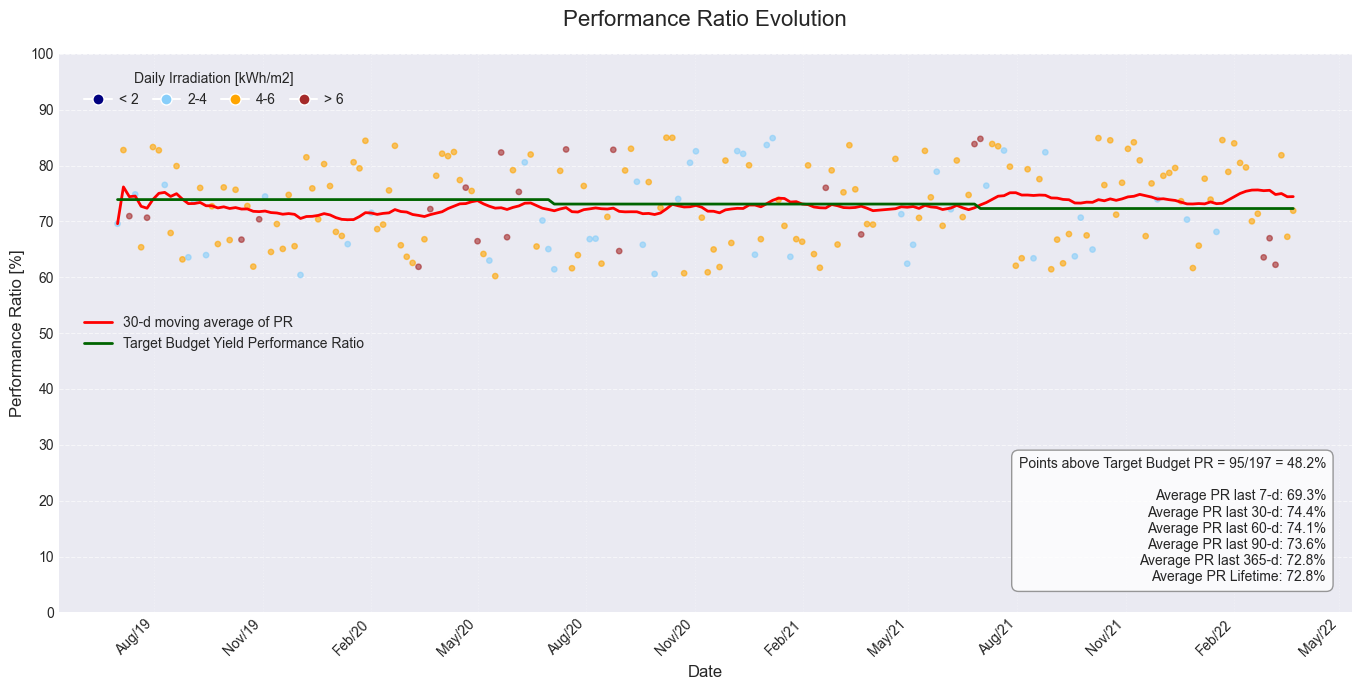


Generating graph for a specific date range (e.g., 2019-12-31 to 2021-12-31)...
Graph saved as 'performance_ratio_evolution_2019-12-31_to_2021-12-31.png'


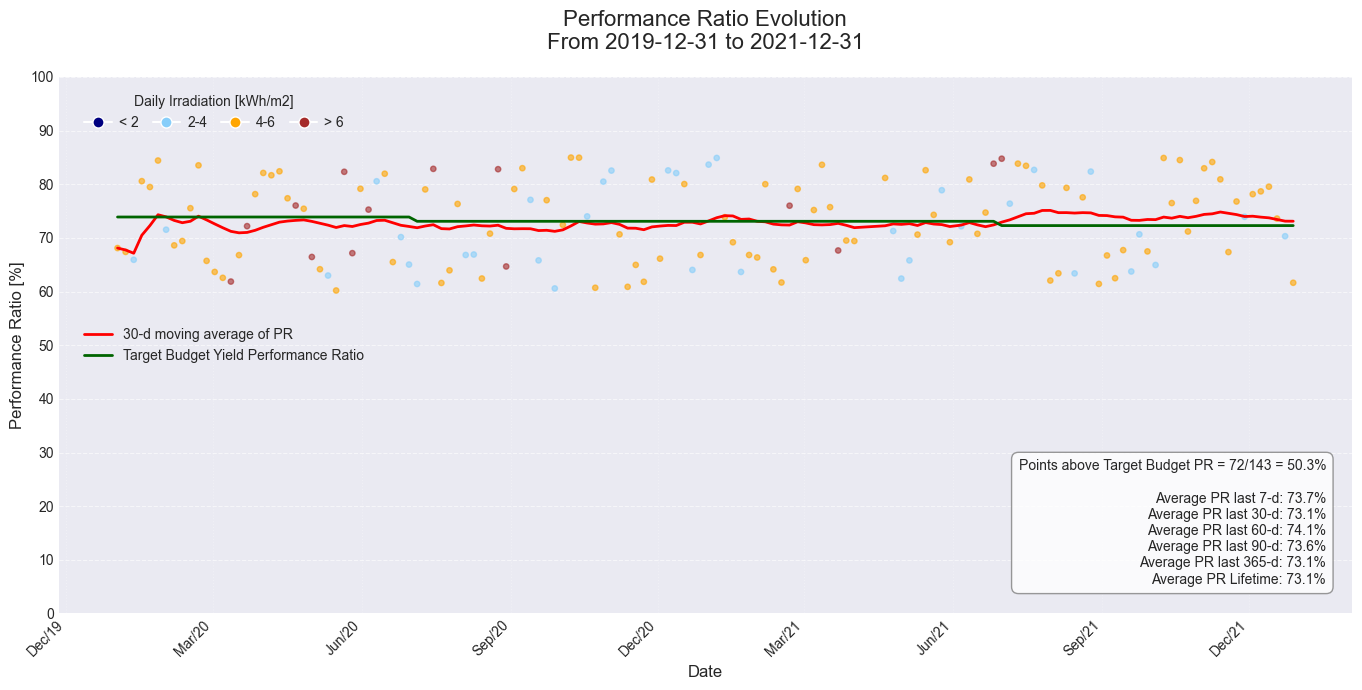


Graphs generated successfully (check your plot window).


In [6]:
# Generate the PR evolution graph with the processed data
if processed_dataframe is not None:
    print("\nGenerating graph for the full dataset...")
    generate_performance_graph(processed_dataframe)

    # Generate graph for a specific date range (example dates)
    print("\nGenerating graph for a specific date range (e.g., 2019-12-31 to 2021-12-31)...")
    generate_performance_graph(processed_dataframe, start_date="2019-12-31", end_date="2021-12-31")    # Adjust these dates based on the actual range of your data if needed.

    print("\nGraphs generated successfully (check your plot window).")
else:
    print("\nFailed to preprocess data. Cannot generate graph.")